# Notebook 6 - Using Total Sky Imager data to pick GOES cloud thresholds

From the Friday Harbor Labs Camera data, we found thresholds using visible reflectivity (green) and infrared (red). This performed well over the San Juan Islands but struggled significantly in mountainous areas with snow and glaciers. Using the decision tree, near IR (blue) was not used because it is unnecessary for precicting cloud cover over ocean/forests. To find the needed threshold combination that will work for those scenes and correctly identify clouds from snow, we will use Total Sky Imager data from Kettle Ponds, Colorado. 

Methods:
1. Process and load TSI data
    - need to ID what spatial domain TSI is looking at to select the correct GOES pixels
2. Load in GOES data for the East River and adjacent environs for Dec-Feb (high snow cover) and Jul-Sep (low/no snow cover)
3. Run the decision tree to find thresholds
    - add depth/branches to the tree to ensure it is using near IR as well as IR and visible

In [1]:
import psutil

# Get CPU usage for each core
cpu_usage_per_core = psutil.cpu_percent(interval=1, percpu=True)

# Print the usage of each core
for i, usage in enumerate(cpu_usage_per_core):
    print(f"Core {i}: {usage}%")

Core 0: 0.0%
Core 1: 0.0%
Core 2: 0.0%
Core 3: 0.0%
Core 4: 0.0%
Core 5: 0.0%
Core 6: 1.0%
Core 7: 1.0%
Core 8: 1.0%
Core 9: 0.0%
Core 10: 0.0%
Core 11: 0.0%
Core 12: 0.0%
Core 13: 0.0%
Core 14: 0.0%
Core 15: 0.0%
Core 16: 0.0%
Core 17: 0.0%
Core 18: 0.0%
Core 19: 1.0%
Core 20: 0.0%
Core 21: 0.0%
Core 22: 0.0%
Core 23: 0.0%


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text


### Section 0 - Define time range

In [3]:
start_time = "2022-07-01"
end_time = "2022-07-31"

# Convert start_time and end_time to numpy.datetime64
start_time = np.datetime64(start_time)
end_time = np.datetime64(end_time)

### Section 1 - Process TSI data

In [20]:
tsi_ds = xr.open_dataset('/storage/cdalden/goes/surface_obs/total_sky_imager/tsi_skycover_20210901_20230616.nc')

# Select time range and filter between hour 14 and 21 UTC in one step
tsi_ds = tsi_ds.sel(
    time=tsi_ds['time'].where(
        (tsi_ds['time'] >= start_time) & 
        (tsi_ds['time'] <= end_time) & 
        (tsi_ds['time'].dt.hour >= 14)
    ).dropna('time')
)

# Create a new cloud binary variable
tsi_ds['cloud_binary'] = xr.where(
    tsi_ds['percent_opaque'] > 0.75, 1,  # Cloudy: Set to 1 when > 0.75
    xr.where(
        (tsi_ds['percent_opaque'] >= 0) & (tsi_ds['percent_opaque'] < 0.50), 0,  # Clear: Set to 0 when >= 0 and < 0.25
        np.nan  # Otherwise, set to NaN (nighttime and mixed cloud cover)
    )
)

tsi_ds.cloud_binary

<xarray.DataArray 'cloud_binary' (time: 35680)> Size: 285kB
array([0., 0., 0., ..., 1., 1., 1.])
Coordinates:
  * time     (time) datetime64[ns] 285kB 2022-07-01T14:00:00 ... 2022-07-30T2...

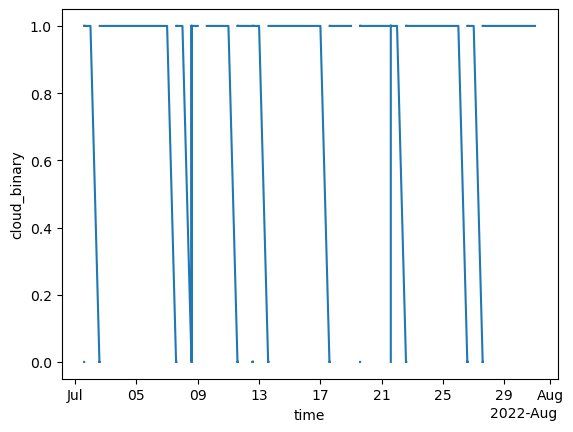

In [21]:
tsi_ds.cloud_binary.plot()

### Section 2 - Compare to GOES pixels

In [22]:
# List to store datasets
datasets = []

# Loop through all the files
for i in range(1, 32):  # Loop from 1 to 29
    # Make i two digits
    day = f"{i:02}"
    filename = f"/storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_202207{day}.nc"
    
    # Open the dataset
    dataset = xr.open_dataset(filename)
    
    # Select pixels where latitude is between 39.065 and 38.904, and longitude is between -107.08 and -106.993
    dataset = dataset.sel(
        latitude=slice(39.065, 38.904),
        longitude=slice(-107.08, -106.993)
    )
    
    # Append the spatially subsetted dataset to the list
    datasets.append(dataset)
    
    print(f"Processed file: {filename}")

# Combine all datasets along the 'time' dimension
# combined_dataset = xr.concat(datasets, dim='t', combine_attrs='override')

# Save the combined dataset to a new NetCDF file
# output_filename = "/storage/cdalden/goes/colorado/goes16/rgb_composite/combined1_goes16_C02_C05_C13_rgb_colorado_202207.nc"
# combined_dataset.to_netcdf(output_filename)


Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20220701.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20220702.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20220703.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20220704.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20220705.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20220706.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20220707.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20220708.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_2022

In [23]:
path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
ds = xr.open_dataset(path + 'combined1_goes16_C02_C05_C13_rgb_colorado_202207.nc')
ds = ds.rename({'t': 'time'})
# ds = ds.drop_dims('time')
ds

<xarray.Dataset> Size: 76MB
Dimensions:    (time: 8928, latitude: 25, longitude: 17)
Coordinates:
  * time       (time) datetime64[ns] 71kB 2022-07-01T00:02:30 ... 2022-07-31T...
  * latitude   (latitude) float64 200B 39.06 39.05 39.05 ... 38.92 38.92 38.91
  * longitude  (longitude) float64 136B -107.1 -107.1 -107.1 ... -107.0 -107.0
Data variables:
    green      (time, latitude, longitude) float32 15MB ...
    blue       (time, latitude, longitude) float64 30MB ...
    red        (time, latitude, longitude) float64 30MB ...

In [24]:
# Compute spatial averages for red, green, and blue bands over x and y dimensions
spatial_avg = ds[['red', 'green', 'blue']].mean(dim=['latitude', 'longitude'])

# Select time range and filter between hour 14 and 21 UTC in one step
spatial_avg = spatial_avg.sel(
    time=spatial_avg['time'].where(
        (spatial_avg['time'] >= start_time) & 
        (spatial_avg['time'] <= end_time) & 
        (spatial_avg['time'].dt.hour >= 14)
    ).dropna('time')
)
# spatial_avg = spatial_avg.compute()
print('done spatial avg')

done spatial avg


In [25]:
print(tsi_ds.nbytes / 1e6, "MB")

8.5632 MB


### Section 3 - Align GOES and TSI data

In [26]:
# Select the nearest TSI timesteps for each spatial_avg timestep
nearest_tsi = tsi_ds['cloud_binary'].sel(time=spatial_avg['time'], method='nearest')
# Ensure no duplicate timestamps in the nearest_tsi dataset
nearest_tsi = nearest_tsi.drop_duplicates(dim='time')
nearest_tsi

<xarray.DataArray 'cloud_binary' (time: 3570)> Size: 29kB
array([0., 1., 1., ..., 1., 1., 1.])
Coordinates:
  * time     (time) datetime64[ns] 29kB 2022-07-01T14:02:30 ... 2022-07-30T23...

In [27]:
spatial_avg

<xarray.Dataset> Size: 101kB
Dimensions:  (time: 3600)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2022-07-01T14:02:30 ... 2022-07-30T23...
Data variables:
    red      (time) float64 29kB 0.004328 0.00227 0.002562 ... 0.5747 0.5841
    green    (time) float32 14kB 0.05062 0.05399 0.058 ... 0.3608 0.343 0.3438
    blue     (time) float64 29kB 0.08441 0.09442 0.1032 ... 0.2978 0.2832 0.2745

In [28]:
spatial_avg['cloud_binary'] = nearest_tsi

goes_tsi_ds = spatial_avg

In [29]:
# Create a mask where all variables are non-NaN
mask = ~goes_tsi_ds.to_array().isnull().any(dim='variable')

# Apply the mask to filter the dataset
goes_tsi_ds = goes_tsi_ds.sel(time=goes_tsi_ds['time'][mask])

goes_tsi_ds

<xarray.Dataset> Size: 126kB
Dimensions:       (time: 3500)
Coordinates:
  * time          (time) datetime64[ns] 28kB 2022-07-01T14:02:30 ... 2022-07-...
Data variables:
    red           (time) float64 28kB 0.004328 0.00227 ... 0.5747 0.5841
    green         (time) float32 14kB 0.05062 0.05399 0.058 ... 0.343 0.3438
    blue          (time) float64 28kB 0.08441 0.09442 0.1032 ... 0.2832 0.2745
    cloud_binary  (time) float64 28kB 0.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

### Section 4 - Create Decision Tree to find thresholds 

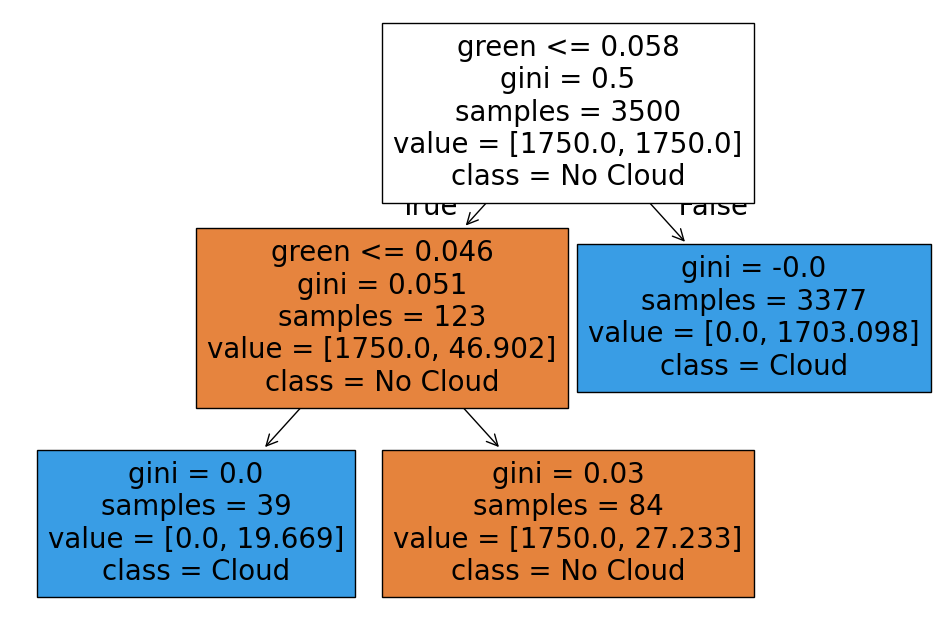

|--- green <= 0.06
|   |--- green <= 0.05
|   |   |--- class: 1.0
|   |--- green >  0.05
|   |   |--- class: 0.0
|--- green >  0.06
|   |--- class: 1.0



In [30]:
# Prepare the data
X = goes_tsi_ds[['red', 'green', 'blue']].to_dataframe().dropna()
y = goes_tsi_ds['cloud_binary'].to_dataframe().loc[X.index]

# Train the decision tree classifier
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=10, class_weight='balanced', random_state=42)  # Limit depth for interpretability
clf.fit(X, y)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['red', 'green', 'blue'], class_names=['No Cloud', 'Cloud'], filled=True)
plt.show()

# Output the decision rules
tree_rules = export_text(clf, feature_names=['red', 'green', 'blue'])
print(tree_rules)

In [18]:
y.sum()

cloud_binary    3470.0
dtype: float64